tgb - 6/24/2019 - The goal of this notebook is to develop diagnostics targeted at the water budget. The motivation is that we would like to understand how enforcing physical constraints affects performance in a high-dimensional system. Since we enforce that the water budget be closed, we can expect some of its macro-diagnostics to be improved. We will:  
1) Load the conserving and unconstrained networks, optimized by Jordan, and compare their respective "average" performances on (+0K),(+4K) and (+3Kw1)    
2) Calculate different terms of the water vapor budget in each dataset  
3) Formally expand conservation penalty in the water vapor budget

# 1) Load networks and compare average performances on different datasets

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages

/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog
/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


Load coordinates

In [2]:
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon;
coor.close();

R2 maps for a given variable from notebook https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/011_Conserving_Network_Paper_Figures.ipynb

In [3]:
# Config and data files
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn_a = ['/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc',
             '/local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc',
             '/local/Tom.Beucler/SPCAM_PHYS/8col009_31_valid.nc']
data_ref = ['','4K','3Kw1']
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}
NNarray = ['JNNL','JNNC','MLRL0','JUnotC']

In [4]:
# Variable and variable's dimension
VAR = 'FLNT'
VARdim = 2;

j= 0 and data from  /local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc
i = 0  so plotting Subplot # 1
Loading model
Loading statistics
JNNL
MSE 148.5863357842754
i = 1  so plotting Subplot # 2
Loading model
Loading statistics
JNNC
MSE 152.4882037592579
i = 2  so plotting Subplot # 3
Loading model
Loading statistics
MLRL0
MSE 295.2749784945916
i = 3  so plotting Subplot # 4
Loading model


ValueError: Unknown metric function:weak_loss_0

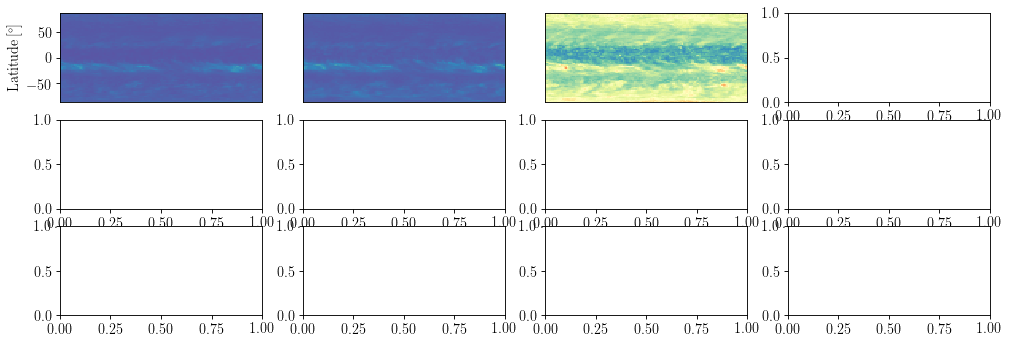

In [5]:
# Loop for R2/penalty performances
msevec = np.zeros((np.size(NNarray),np.size(data_ref),218))

# Prepare figure
fz = 13; # Fontsize
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)
fig, axes = plt.subplots(nrows=len(data_fn_a), ncols=len(NNarray),\
                        num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')

# Start loop
for j,data_fn in enumerate(data_fn_a):
    print('j=',j,'and data from ',data_fn)
    for i,NNs in enumerate(NNarray):
        print('i =',i,' so plotting Subplot #',i+1+j*len(NNarray))
        # Load statistics
        md = {}; NN = {};
        print('Loading model') # 1) Load model
        NN = load_model(TRAINDIR+'HDF5_DATA/'+NNs+'.h5',custom_objects=dict_lay)
        print('Loading statistics') # 2) Define model diagnostics object
        md = ModelDiagnostics(NN,config_fn,data_fn)
        
        # 3) Calculate statistics and save in pickle file
        path_end = 'md'+data_ref[j]+'.pkl'
        pathres = 'mdres'+data_ref[j]+'.pkl'
        md.stats = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNs+path_end,'rb'))
        #md.res = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNs+pathres,'rb'))

        print(NNs)
        print('MSE',md.mse_W2m4().mean((0,1,2)))
        msevec[i,j,:] = md.mse_W2m4().mean((0,1)) # Save the MSE for each output
#         print('PEN',0.25*(md.res['mass']+md.res['ent']+\
#                           md.res['sw']+md.res['lw']).mean((0,1,2)))
#         print('PEN_MASS',0.25*(md.res['mass']).mean((0,1,2)))
#         print('PEN_ENT',0.25*(md.res['ent']).mean((0,1,2)))
#         print('PEN_LW',0.25*(md.res['lw']).mean((0,1,2)))
#         print('PEN_SW',0.25*(md.res['sw']).mean((0,1,2)))
        
        if VARdim==3: A = np.expand_dims(md.stats['r2']\
                                         [:, :, md.get_output_var_idx(VAR)[15:30]].mean(axis=2),axis=2).T;
        else: A = md.stats['r2'][:, :, md.get_output_var_idx(VAR)].T; # When single-valued variable
        AX = axes.flat[i+j*len(NNarray)]
        im = AX.pcolor(lon,lat,A[0,:,:].T,cmap='Spectral',vmin=0,vmax=1)
        #AX.set_title(TITarray[i+j*len(NNarray)])
        if j+1==len(data_fn_a): AX.set_xlabel(r'$\mathrm{Longitude}\left[^{\circ}\right]$')
        else: AX.get_xaxis().set_ticks([])
        if i==0: AX.set_ylabel(r'$\mathrm{Latitude}\left[^{\circ}\right]$')
        else: AX.get_yaxis().set_ticks([])

# 2) Water vapor budget terms

## 2.1) Develop diagnostics

### 2.1.1) Define models

In [6]:
# Config and data files
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn_a = ['/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc',
             '/local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc',
             '/local/Tom.Beucler/SPCAM_PHYS/8col009_31_valid.nc']
data_ref = ['','4K','3Kw1']
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
           'weak_loss_0':mse,'weak_loss_1':mse}
NNarray = ['JUnotC','JNNL','JNNC','MLRL0','JNNL0.01']

In [7]:
index = 0; # Choose dataset from data_fn_a [0 is +0K of length 5172]
lat_ind = [31,32] # index over which we evaluate generalization performances

NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = TRAINDIR+'HDF5_DATA/'+NNs+'.h5'
    NN[NNs] = load_model(path,custom_objects=dict_lay)
    md[NNs] = ModelDiagnostics(NN[NNs],config_fn,data_fn_a[index])

W0804 16:41:59.425288 22943615391552 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0804 16:41:59.425999 22943615391552 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0804 16:41:59.428167 22943615391552 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (

/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
NN name is  JUnotC


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  JNNL


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  JNNC


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
W0804 16:42:05.663691 22943615391552 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


NN name is  MLRL0


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  JNNL0.01


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


### 2.1.2) Loop over each timestep and decompose the residual into error on each budget term

In [11]:
# tgb - 6/24/2019 - Define diagnostics to calculate residual from water budget
def dec_res(md, inp, pred):
    inp_div = md.valid_gen.input_transform.div
    inp_sub = md.valid_gen.input_transform.sub
    norm_q = md.valid_gen.output_transform.scale[md.get_output_var_idx('PHQ')]

    # Input
    PS_idx = 300
    LHFLX_idx = 303

    # Output
    PHQ_idx = slice(0, 30)
    PHCLDLIQ_idx = slice(30, 60)
    PHCLDICE_idx = slice(60, 90)
    PRECT_idx = 214
    PRECTEND_idx = 215

    # 1. Compute dP_tilde
    dP_tilde = compute_dP_tilde(inp[:, PS_idx],  inp_div[PS_idx], inp_sub[PS_idx], norm_q, hyai, hybi)

    # 2. Compute water integral
    WATINT = np.sum(dP_tilde *(pred[:, PHQ_idx] + pred[:, PHCLDLIQ_idx] + pred[:, PHCLDICE_idx]), axis=1)

    # 3. Compute latent heat flux and precipitation forcings
    LHFLX = inp[:, LHFLX_idx] * inp_div[LHFLX_idx] + inp_sub[LHFLX_idx]
    PREC = pred[:, PRECT_idx] + pred[:, PRECTEND_idx]

    # 4. Compute water mass residual
    WATRES = LHFLX - PREC - WATINT

    # 5. Put all terms of water vapor budget in a dictionary
    BUD = {}
    BUD['TOT'] = WATRES
    BUD['LHF'] = LHFLX
    BUD['PREC'] = -PREC
    BUD['WAT'] = -WATINT
    
    return BUD

tgb - 6/26/2019 - Repeat for enthalpy

In [10]:
def entdec_res(self,inp,pred):
    inp_div = self.valid_gen.input_transform.div
    inp_sub = self.valid_gen.input_transform.sub
    norm_q = self.valid_gen.output_transform.scale[self.get_output_var_idx('PHQ')]

    # Input
    PS_idx = 300
    SHFLX_idx = 302
    LHFLX_idx = 303

    # Output
    PHQ_idx = slice(0, 30)
    PHCLDLIQ_idx = slice(30, 60)
    PHCLDICE_idx = slice(60, 90)
    TPHYSTND_idx = slice(90, 120)
    DTVKE_idx = slice(180, 210)
    FSNT_idx = 210
    FSNS_idx = 211
    FLNT_idx = 212
    FLNS_idx = 213
    PRECT_idx = 214
    PRECTEND_idx = 215
    PRECST_idx = 216
    PRECSTEND_idx = 217

    # 1. Compute dP_tilde
    dP_tilde = compute_dP_tilde(inp[:, PS_idx],  inp_div[PS_idx], inp_sub[PS_idx], norm_q, hyai, hybi)

    # 2. Compute net energy input from phase change and precipitation
    PHAS = L_I / L_V * (
            (pred[:, PRECST_idx] + pred[:, PRECSTEND_idx]) -
            (pred[:, PRECT_idx] + pred[:, PRECTEND_idx])
    )

    # 3. Compute net energy input from radiation, SHFLX and TKE
    RAD = (pred[:, FSNT_idx] - pred[:, FSNS_idx] -
           pred[:, FLNT_idx] + pred[:, FLNS_idx])
    SHFLX = (inp[:, SHFLX_idx] * inp_div[SHFLX_idx] +
             inp_sub[SHFLX_idx])
    KEDINT = np.sum(dP_tilde * pred[:, DTVKE_idx], 1)

    # 4. Compute tendency of vapor due to phase change
    LHFLX = (inp[:, LHFLX_idx] * inp_div[LHFLX_idx] +
             inp_sub[LHFLX_idx])
    VAPINT = np.sum(dP_tilde * pred[:, PHQ_idx], 1)
    SPDQINT = (VAPINT - LHFLX) * L_S / L_V

    # 5. Same for cloud liquid water tendency
    SPDQCINT = np.sum(dP_tilde * pred[:, PHCLDLIQ_idx], 1) * L_I / L_V

    # 6. And the same for T but remember residual is still missing
    DTINT = np.sum(dP_tilde * pred[:, TPHYSTND_idx], 1)

    # 7. Compute enthalpy residual
    ENTRES = SPDQINT + SPDQCINT + DTINT - RAD - SHFLX - PHAS - KEDINT
    
    # 8. Isolate four terms and cross terms
    BUD = {}
    BUD['TOT'] = ENTRES
    BUD['THERMO'] = SPDQINT + SPDQCINT + DTINT - KEDINT + L_S/L_V*LHFLX
    BUD['RAD'] = -RAD
    BUD['PHAS'] = -PHAS
    BUD['SHFLX'] = -SHFLX-L_S/L_V*LHFLX

    return BUD

The goal is to relate how much our neural network violates the physical
constraints to its performances. Quantitatively, we relate the residual
of a budget (e.g. water) to the error of each of the budget's terms
(i.e. how much the budget's term deviates from the truth): 
$$
\begin{aligned}\mathrm{Residual_{pred}} & \overset{\mathrm{def}}{=}\left(\mathrm{EVAP_{pred}-WATINT_{pred}-PREC_{pred}}\right)^{2}\\
 & =\left(\mathrm{EVAP_{error}-WATINT_{error}-PREC_{error}}\right)^{2}
\end{aligned}
$$
where the error of each component is defined as:
$$
X_{\mathrm{error}}\overset{\mathrm{def}}{=}X_{\mathrm{pred}}-X_{\mathrm{truth}}
$$
and we have used the fact that the residual was 0 for the ``truth'':
$$
\mathrm{Residual_{truth}}=0\ \Rightarrow\ \left(\mathrm{EVAP_{pred}-WATINT_{pred}-PREC_{pred}}\right)=0
$$
We can therefore write $\mathrm{Residual_{pred}}\ $as a function
of the mean-squared-error of each term and the cross-product of different
errors. Since $\mathrm{EVAP}\ $is an input, $\mathrm{EVAP_{error}=0}\ $and:
$$
\mathrm{Residual_{pred}}=\mathrm{WATINT_{error}^{2}+PREC_{error}^{2}+2PREC_{error}\times WATINT_{error}}
$$
This can be decomposed further by decomposing $\mathrm{WATINT,PREC\ }$into
its different terms. Because enforcing physical constraints sets $\mathrm{Residual_{pred}}\ $to
0, it constrains the performances of the network ($\mathrm{WATINT_{error}^{2},PREC_{error}^{2}}$)
via the equation above.
\end{document}


In [9]:
# tgb - 7/3/2019 - Choose number of timesteps
nt = 1000

## 2.2) Water

In [14]:
NNarray = ['JUnotC','JNNL','JNNC','MLRL0','JNNL0.01']
#NNarray = ['JUnotC','JNNL0.01','JNNC']
Bdic = ['TOT','LHF','PREC','WAT']
Rdic = ['TOT','PREC','WAT','CROSS']
# Allocate stats arrays
for i,NNs in enumerate(NNarray):
    md[NNs].bud = {}; md[NNs].err = {};
    md[NNs].tru = {};
    M = md[NNs]
    bud = {}; tru = {}; err = {}; 
    for iB,Bs in enumerate(Bdic):
            bud[Bs] = np.zeros((M.nlat, M.nlon,1))
            tru[Bs] = np.copy(bud[Bs])
    for iR,Rs in enumerate(Rdic):
            err[Rs] = np.zeros((M.nlat, M.nlon,1))
    for itime in tqdm(range(nt)):
        inp, p, truth = M.get_inp_pred_truth(itime)  # [lat, lon, var, lev]
        # residuals
        R = dec_res(M,inp,p) # Predicted water budget
        T = dec_res(M,inp,truth) # True water budget
        # Budget terms
        for iB,Bs in enumerate(Bdic):
            bud[Bs] += M.reshape_ngeo(R[Bs])
            tru[Bs] += M.reshape_ngeo(T[Bs])
        # Absolute errors
        err['PREC'] += M.reshape_ngeo(np.square(R['PREC']-T['PREC']))
        err['WAT'] += M.reshape_ngeo(np.square(R['WAT']-T['WAT']))
        err['CROSS'] += 2*M.reshape_ngeo((R['WAT']-T['WAT'])*(R['PREC']-T['PREC'])+\
                                        (R['LHF']-T['LHF'])*(R['PREC']-T['PREC'])+\
                                         (R['WAT']-T['WAT'])*(R['LHF']-T['LHF']))
        # err['TOT']>bud['TOT'] because we are taking the square
        err['TOT'] += M.reshape_ngeo(np.square(R['TOT']-T['TOT'])) 
            
    # Compute average statistics
    for iR,Rs in enumerate(Rdic):
        md[NNs].err[Rs] = err[Rs]/nt # Budget term in W2/m4
    for iB,Bs in enumerate(Bdic):
        md[NNs].bud[Bs] = bud[Bs]/nt # Budget term in W2/m4
        md[NNs].tru[Bs] = tru[Bs]/nt # True budget term in W2/m4

In [15]:
import pickle
for i,NNs in enumerate(NNarray):
    filename = '7_3_Water_'+data_fn_a[index][-19:-1]+'_'+NNs+'.h5'
    print(filename)
    hf = open(filename,'wb')
    Water = {"budget":md[NNs].bud,
                "truth":md[NNs].tru,
                "error":md[NNs].err,
                "nt":nt}
    pickle.dump(Water,hf)
    hf.close()

7_3_Water_8col009_01_valid.n_JUnotC.h5
7_3_Water_8col009_01_valid.n_JNNL.h5
7_3_Water_8col009_01_valid.n_JNNC.h5
7_3_Water_8col009_01_valid.n_MLRL0.h5
7_3_Water_8col009_01_valid.n_JNNL0.01.h5


## 2.3) Enthalpy

In [11]:
NNarray = ['JUnotC','JNNL','JNNC','MLRL0','JNNL0.01']
#NNarray = ['JUnotC','JNNL0.01','JNNC']
Bdic = ['TOT','THERMO','RAD','PHAS','SHFLX']
Rdic = ['TOT','THERMO','RAD','PHAS','SHFLX','CROSS']
# Allocate stats arrays
for i,NNs in enumerate(NNarray):
    md[NNs].bud = {}; md[NNs].err = {};
    md[NNs].tru = {};
    M = md[NNs]
    bud = {}; tru = {}; err = {}; 
    for iB,Bs in enumerate(Bdic):
            bud[Bs] = np.zeros((M.nlat, M.nlon,1))
            tru[Bs] = np.copy(bud[Bs])
    for iR,Rs in enumerate(Rdic):
            err[Rs] = np.zeros((M.nlat, M.nlon,1))
    for itime in tqdm(range(nt)):
        inp, p, truth = M.get_inp_pred_truth(itime)  # [lat, lon, var, lev]
        # residuals
        R = entdec_res(M,inp,p) # Predicted water budget
        T = entdec_res(M,inp,truth) # True water budget
        E = {}
        for iB,Bs in enumerate(Bdic):
            E[Bs] = R[Bs]-T[Bs] # Error
        # Budget terms
        for iB,Bs in enumerate(Bdic):
            bud[Bs] += M.reshape_ngeo(R[Bs])
            tru[Bs] += M.reshape_ngeo(T[Bs])
        # Absolute errors
        for iB,Bs in enumerate(Bdic):
            err[Bs] += M.reshape_ngeo(np.square(E[Bs]))
        err['CROSS'] += 2*M.reshape_ngeo(E['THERMO']*\
                                         (E['RAD']+E['PHAS']+E['SHFLX'])+\
                                         E['RAD']*\
                                         (E['THERMO']+E['PHAS']+E['SHFLX'])+\
                                         E['PHAS']*\
                                         (E['THERMO']+E['RAD']+E['SHFLX'])+\
                                         E['SHFLX']*\
                                         (E['THERMO']+E['RAD']+E['PHAS']))
    # Compute average statistics
    for iR,Rs in enumerate(Rdic):
        md[NNs].err[Rs] = err[Rs]/nt # Budget term in W2/m4
    for iB,Bs in enumerate(Bdic):
        md[NNs].bud[Bs] = bud[Bs]/nt # Budget term in W2/m4
        md[NNs].tru[Bs] = tru[Bs]/nt # True budget term in W2/m4

In [4]:
# import pickle
# for i,NNs in enumerate(NNarray):
#     filename = '7_3_Enthalpy_'+data_fn_a[index][-19:-1]+'_'+NNs+'.h5'
#     print(filename)
#     hf = open(filename,'wb')
#     Enthalpy = {"budget":md[NNs].bud,
#                 "truth":md[NNs].tru,
#                 "error":md[NNs].err,
#                 "nt":nt}
#     pickle.dump(Enthalpy,hf)
#     hf.close()

In [8]:
index = 0
var = 'Enthalpy'

if index==0:
    lat_ind = np.arange(0,64)
elif index==1:
    #lat_ind = [30,33]
    lat_ind = np.arange(0,64)

if var=='Water':
    Bdic = ['TOT','LHF','PREC','WAT']; 
    Rdic = ['TOT','PREC','WAT','CROSS']
elif var=='Enthalpy':
    Bdic = ['TOT','THERMO','RAD','PHAS','SHFLX'];
    Rdic = ['TOT','THERMO','RAD','PHAS','SHFLX','CROSS'];
    
import pickle
M = {}
for i,NNs in enumerate(NNarray):
    filename = '7_3_'+var+'_'+data_fn_a[index][-19:-1]+'_'+NNs+'.h5'
    hf = open(filename,'rb')
    M[NNs] = pickle.load(hf)

In [9]:
filename

'7_3_Enthalpy_8col009_01_valid.n_JNNL0.01.h5'

In [10]:
# VAR = 'THERMO'
# vmin = -0.5
# vmax = 2.5
# levels = np.linspace(vmin, vmax, 4)

# v1 = M['JNNL']['error']['THERMO'][:,:,0]
# v2 = M['JNNC']['error']['THERMO'][:,:,0]
# v3 = M['JNNL']['error']['TOT'][:,:,0]

# plt.figure(figsize=(10,3))

# #plt.subplot(2,1,1)
# plt.contourf(coor.lon,coor.lat,(v1-v2)/v3,cmap='RdBu',levels=levels)
# plt.colorbar()
#plt.subplot(2,1,2)
#plt.imshow(v3,vmin=vmin,vmax=vmax)
#plt.colorbar()

/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10
/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


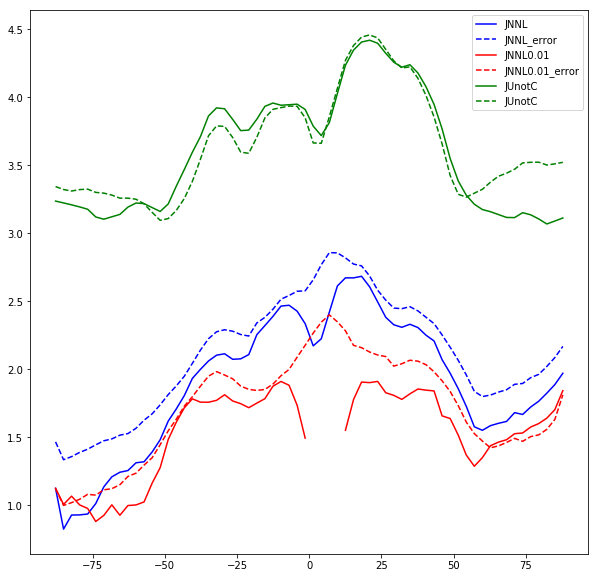

In [19]:
VAR = 'THERMO'

v1 = M['JNNL']['error']['THERMO'][:,:,0].mean(axis=1)
v2 = M['JNNC']['error']['THERMO'][:,:,0].mean(axis=1)
v3 = M['JNNL']['error']['TOT'][:,:,0].mean(axis=1)

w1 = M['JNNL0.01']['error']['THERMO'][:,:,0].mean(axis=1)
w3 = M['JNNL0.01']['error']['TOT'][:,:,0].mean(axis=1)

u1 = M['JUnotC']['error']['THERMO'][:,:,0].mean(axis=1)
u3 = M['JUnotC']['error']['TOT'][:,:,0].mean(axis=1) 

plt.figure(figsize=(10,10))

plt.plot(coor.lat,np.log10(v1-v2),label='JNNL',color='b')
plt.plot(coor.lat,np.log10(v3),label='JNNL_error',color='b',linestyle='--')
plt.plot(coor.lat,np.log10(w1-v2),label='JNNL0.01',color='r')
plt.plot(coor.lat,np.log10(w3),label='JNNL0.01_error',color='r',linestyle='--')
plt.plot(coor.lat,np.log10(u1-v2),label='JUnotC',color='g')
plt.plot(coor.lat,np.log10(u3),label='JUnotC',color='g',linestyle='--')
#plt.plot(coor.lat,v2,label='JNNC')
#plt.plot(coor.lat,M['JNNL']['error']['TOT'][:,:,0].mean(axis=1),label='JNNL penalty')
plt.axhline(y=np.log10(0),color='k')
plt.legend()

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/api/_v1/keras/models/__init__.py:39: RuntimeWarning: invalid value encountered in log10


[Text(1, 0, '$10^0$'),
 Text(1, 0, '$10^1$'),
 Text(1, 0, '$10^2$'),
 Text(1, 0, '$10^3$'),
 Text(1, 0, '$10^4$'),
 Text(1, 0, '$10^5$')]

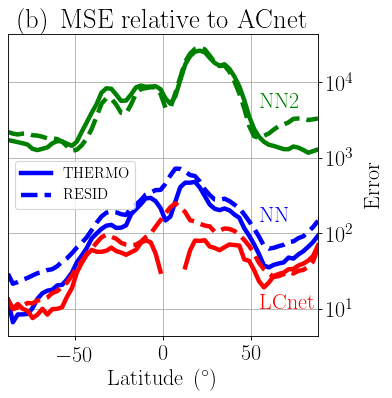

In [68]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag

cplot = ['b','r','g']
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
           'weak_loss_0':mse,'weak_loss_1':mse}
NNplot = ['JNNL','JNNL0.01','JUnotC']
NNsREF = 'JNNC'
VAR = 'THERMO'

fz = 20
LAB = [r'$\mathrm{THERMO}$','','',r'$\mathrm{RESID}$','','']
lw = 4
siz = 100
S0 = 320 # Representative mean solar insolation for normalization purposes
S0max = 1410.6442 # Max solar insolation for normalization purposes
SN = S0/100 # Representative target = mean insolation / 4
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YMIN = -1 # Representative value for conserving network
YTEXT = 0.3 # Text placement

MSEs = {}; PENs = {}; ax = {};

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)

mpl.rcParams['lines.linewidth'] = lw
plt.close('all')
f = plt.figure(num=None, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
ax = f.add_subplot(111)

REF = M[NNsREF]['error']['THERMO'][:,:,0].mean(axis=1)

ETHERMOs = {}; ETOTs = {};
for imodel,NNs in enumerate(NNplot):
    ETHERMOs[NNs] = plt.plot(coor.lat,\
                             np.log10(M[NNs]['error'][VAR][:,:,0].mean(axis=1)-REF),\
                             color=cplot[imodel],label=LAB[imodel])
    ETOTs[NNs] = plt.plot(coor.lat,\
                          np.log10(M[NNs]['error']['TOT'][:,:,0].mean(axis=1)),\
                          color=cplot[imodel],linestyle='--',label=LAB[np.size(NNplot)+imodel])

plt.grid()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.xlim((np.min(coor.lat),np.max(coor.lat)))

# Text
N2NETt = plt.text(55,3.65,s='$\mathrm{NN2}$',color='g')
NNETt = plt.text(55,2.15,s='$\mathrm{NN}$',color='b')
LCNETt = plt.text(55,1,s='$\mathrm{LCnet}$',color='r')

# plt.ylim((YMIN,3.33))
plt.xlabel(r'$\mathrm{Latitude\ \left(^{\circ}\right)}$')
plt.ylabel(r'$\mathrm{Error}$',labelpad=10)
plt.title(r'$\mathrm{\left(b\right)\ MSE\ relative\ to\ ACnet}$')
plt.legend(loc='center left',fontsize=2*fz/3)

# Change y labels to 10^n
# labels = [item.get_text() for item in ax.get_yticklabels()]
# print(labels)
# for ilab,lab in enumerate(labels):
#     print(ilab,lab)
#     labels[ilab]='$10^'+lab[1:2]+'$'
ax.set_yticklabels(labels)


In [65]:
labels
labels = [item.get_text() for item in ax.get_yticklabels()]
for ilab,lab in enumerate(labels):
    print(lab)
    labels[ilab]='$10^'+lab[1:2]+'$'
print(labels)

$0$
$1$
$2$
$3$
$4$
$5$
['$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$']


In [36]:
SST = [0,4]
NNarray = ['JNNL','JNNC','JNNL0.01','JUnotC','MLRL0']
MSEarray = {}
Parray = {}

for j,sst in enumerate(SST):
    MSEarray[sst] = {}
    Parray[sst] = {}
    #print('j=',j,'and sst=',sst)
    if sst==0: data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
    else: data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_1'+str(sst)+'_valid.nc'
    for i,NNs in enumerate(NNarray):
        #plt.subplot(2, len(NNarray), i+1+j*len(NNarray))
        print('i =',i,' so plotting Subplot #',i+1+j*len(NNarray))
        # Load statistics
        md = {}; NN = {};
        #print('Loading model') # 1) Load model
        NN = load_model(TRAINDIR+'HDF5_DATA/'+NNs+'.h5',custom_objects=dict_lay)
        #print('Loading statistics') # 2) Define model diagnostics object
        print(NNs)
        md = ModelDiagnostics(NN,config_fn,data_fn)
        # 3) Calculate statistics and save in pickle file
        if sst==0: path_end = 'md.pkl'
        else: path_end = 'md'+str(sst)+'K.pkl'
        md.stats = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNs+path_end,'rb'))
        print('Error',NNs,sst,'=','%.2e'%md.mse_W2m4().mean((0,1,2)),\
         '+-','%.2e'%md.mse_W2m4().std((0,1,2)))
        MSEarray[sst][NNs] = {}
        STRm = ["%.1e" %md.mse_W2m4().mean((0,1,2))]
        STRs = ["%.1e" %md.mse_W2m4().std((0,1,2))]
        MSEarray[sst][NNs][0] = STRm
        MSEarray[sst][NNs][1] = STRs
        # 4) Residual
        if sst==0: path_end = 'mdres.pkl'
        else: path_end = 'mdres'+str(sst)+'K.pkl'
        md.res = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNs+path_end,'rb'))
        RES = 0.25*(md.res['mass']+md.res['ent']+md.res['sw']+md.res['lw'])
        print('Residual',NNs,sst,'=','%.2e'%RES.mean((0,1,2)),'+-','%.2e'%RES.std((0,1,2)))
        Parray[sst][NNs] = {}
        STRm = ["%.1e" %RES.mean((0,1,2))]
        STRs = ["%.1e" %RES.std((0,1,2))]
        Parray[sst][NNs][0] = STRm
        Parray[sst][NNs][1] = STRs

i = 0  so plotting Subplot # 1
JNNL
Error JNNL 0 = 1.49e+02 +- 9.44e+02
Residual JNNL 0 = 9.14e+01 +- 8.19e+01
i = 1  so plotting Subplot # 2
JNNC
Error JNNC 0 = 1.52e+02 +- 9.63e+02
Residual JNNC 0 = 7.71e-10 +- 1.35e-09
i = 2  so plotting Subplot # 3
JNNL0.01
Error JNNL0.01 0 = 1.51e+02 +- 9.51e+02
Residual JNNL0.01 0 = 3.81e+01 +- 2.85e+01
i = 3  so plotting Subplot # 4
JUnotC
Error JUnotC 0 = 3.40e+02 +- 2.18e+03
Residual JUnotC 0 = 2.87e+03 +- 3.36e+03
i = 4  so plotting Subplot # 5
MLRL0
Error MLRL0 0 = 2.95e+02 +- 1.69e+03
Residual MLRL0 0 = 2.77e+01 +- 2.32e+01
i = 0  so plotting Subplot # 6
JNNL
Error JNNL 4 = 3.46e+02 +- 3.62e+03
Residual JNNL 4 = 2.65e+02 +- 5.58e+02
i = 1  so plotting Subplot # 7
JNNC
Error JNNC 4 = 3.62e+02 +- 4.32e+03
Residual JNNC 4 = 1.38e-09 +- 2.89e-09
i = 2  so plotting Subplot # 8
JNNL0.01
Error JNNL0.01 4 = 3.68e+02 +- 4.25e+03
Residual JNNL0.01 4 = 2.46e+02 +- 7.26e+02
i = 3  so plotting Subplot # 9
JUnotC
Error JUnotC 4 = 4.45e+02 +- 2.60e+03
Res

In [51]:
MSEarray[0]['JNNL'][1][0][-1:]

'2'

tgb - 7/9/2019 - Create tex file automatically

In [37]:
# !ls

In [56]:
NNarray = ['MLRL0','JNNL','JUnotC','JNNL0.01','JNNC']

f= open("TXT_DATA/Table01.txt","w+")
f.write("\\begin{table}[H]\n")
f.write("\\begin{centering}\n")
f.write("{\\small{}}%\n")
f.write("\\begin{tabular}{c|c|ccccc}\n")
f.write("{\\small{}Validation} & {\\small{}Metric} & {\\small{}Linear} & Unconstrained & $\\mathrm{Unconstrained_{2}}$ & $\\mathrm{LC_{net\\left(\\alpha=0.01\\right)}}$ & $\\mathrm{AC_{net}}$\\tabularnewline\n")
f.write("\\hline\n") 
f.write("{\\small{}Baseline skill} & {\\small{}$\\mathrm{MSE}$} &")
for i,NNs in enumerate(NNarray):
    f.write(" {\\small{}$")
    f.write(MSEarray[0][NNs][0][0][:3])
    f.write("\\ 10^{")
    f.write(MSEarray[0][NNs][0][0][-1:])
    f.write("}\\pm")
    f.write(MSEarray[0][NNs][1][0][:3])
    f.write("\\ 10^{")
    f.write(MSEarray[0][NNs][1][0][-1:])
    f.write("}$}")
    if i<np.size(NNarray)-1: f.write(" &")
    else: f.write("\\tabularnewline\n")
    #f.write(" {\\small{}$295\\pm1.7.10^{3}$} & {\\small{}$156\\pm1.0\\ 10^{3}$} & {\\small{}$156\\pm1.0\\ 10^{3}$} & {\\small{}$154\\pm1.0\\ 10^{3}$} & {\\small{}$177\\pm1.1\\ 10^{3}$}\\tabularnewline\n")
f.write("(+0K) & {\\small{}${\\cal P}$} &")
for i,NNs in enumerate(NNarray):
    f.write(" {\\small{}$")
    f.write(Parray[0][NNs][0][0][:3])
    f.write("\\ 10^{")
    f.write(Parray[0][NNs][0][0][-1:])
    f.write("}\\pm")
    f.write(Parray[0][NNs][1][0][:3])
    f.write("\\ 10^{")
    f.write(Parray[0][NNs][1][0][-1:])
    f.write("}$}")
    if i<np.size(NNarray)-1: f.write(" &")
    else: f.write("\\tabularnewline\n")
#f.write("(+0K) & {\\small{}${\\cal P}$} & {\\small{}$28\\pm2\\ 10^{1}$} & {\\small{}$458\\pm5\\ 10^{2}$} & {\\small{}$156\\pm1.0\\ 10^{3}$} & {\\small{}$125\\pm2\\ 10^{2}$} & {\\small{}$5.0\\pm5$}\\tabularnewline\n")
f.write("\\cline{1-1}\n")
f.write("Uni. warming & {\\small{}$\mathrm{MSE}$} &")
for i,NNs in enumerate(NNarray):
    f.write(" {\\small{}$")
    f.write(MSEarray[4][NNs][0][0][:3])
    f.write("\\ 10^{")
    f.write(MSEarray[4][NNs][0][0][-1:])
    f.write("}\\pm")
    f.write(MSEarray[4][NNs][1][0][:3])
    f.write("\\ 10^{")
    f.write(MSEarray[4][NNs][1][0][-1:])
    f.write("}$}")
    if i<np.size(NNarray)-1: f.write(" &")
    else: f.write("\\tabularnewline\n")
#f.write("Uni. warming & {\\small{}$\mathrm{MSE}$} & {\\small{}$747\\pm1\\ 10^{5}$} & {\\small{}$633\\pm7\\ 10^{3}$} & {\\small{}$156\\pm1.0\\ 10^{3}$} & {\\small{}$471\\pm5\\ 10^{3}$} & {\\small{}$496\\pm8\\ 10^{3}$}\\tabularnewline\n")
f.write("(+4K) & {\\small{}${\\cal P}$} &")
for i,NNs in enumerate(NNarray):
    f.write(" {\\small{}$")
    f.write(Parray[4][NNs][0][0][:3])
    f.write("\\ 10^{")
    f.write(Parray[4][NNs][0][0][-1:])
    f.write("}\\pm")
    f.write(Parray[4][NNs][1][0][:3])
    f.write("\\ 10^{")
    f.write(Parray[4][NNs][1][0][-1:])
    f.write("}$}")
    if i<np.size(NNarray)-1: f.write(" &")
    else: f.write("\\tabularnewline\n")
#f.write("(+4K) & {\\small{}${\\cal P}$} & {\\small{}$265\\pm2\\ 10^{3}$} & {\\small{}$3\\ 10^{5}\\pm1\\ 10^{6}$} & {\\small{}$156\\pm1.0\\ 10^{3}$} & {\\small{}$2\\ 10^{3}\\pm1\\ 10^{4}$} & {\\small{}$470\\pm2\\ 10^{3}$}\\tabularnewline\n")
f.write("\\hline\n") 
f.write("\\end{tabular}\n")
f.write("\\par\\end{centering}{\\small \\par}\n")
f.write("\n")
f.write("\\caption{Summary table (MSE/Penalty)}\n")
f.write("\\end{table}\n")
f.close()

In [90]:
md.res = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNs+path_end,'rb'))
RES = 0.25*(md.res['mass']+md.res['ent']+md.res['sw']+md.res['lw'])

AttributeError: 'dict' object has no attribute 'res'

In [78]:
0.25*(md.res['mass']+md.res['ent']+\
                   md.res['sw']+md.res['lw']).mean((0,1,2))

91.35458150483636

In [42]:
LAB = ['a','','','b','','']

In [48]:
np.size(NNplot)

3

In [87]:
NNs = 'JNNL'
for iR,Rs in enumerate(Rdic):
    print('Error',Rs,'=','%.2e'%M[NNs]['error'][Rs][lat_ind,:,0].mean(axis=(0,1)),\
         '+-','%.2e'%M[NNs]['error'][Rs][lat_ind,:,0].std(axis=(0,1)))

Error TOT = 5.14e+02 +- 2.17e+03
Error PREC = 1.22e+04 +- 2.90e+04
Error WAT = 1.25e+04 +- 2.84e+04
Error CROSS = -2.42e+04 +- 5.59e+04


In [88]:
NNs = 'JNNC'
for iR,Rs in enumerate(Rdic):
    print('Error',Rs,'=','%.2e'%M[NNs]['error'][Rs][lat_ind,:,0].mean(axis=(0,1)),\
         '+-','%.2e'%M[NNs]['error'][Rs][lat_ind,:,0].std(axis=(0,1)))

Error TOT = 7.88e-03 +- 2.53e-01
Error PREC = 1.59e+04 +- 5.63e+04
Error WAT = 1.59e+04 +- 5.63e+04
Error CROSS = -3.19e+04 +- 1.13e+05


In [65]:
NNs = 'JNNL0.01'
for iR,Rs in enumerate(Rdic):
    print('Error',Rs,'=','%.2e'%M[NNs]['error'][Rs][lat_ind,:,0].mean(axis=(0,1)),\
         '+-','%.2e'%M[NNs]['error'][Rs][lat_ind,:,0].std(axis=(0,1)))

Error TOT = 7.39e+01 +- 6.34e+01
Error THERMO = 2.08e+02 +- 2.57e+02
Error RAD = 6.09e+01 +- 2.80e+01
Error PHAS = 7.82e+01 +- 1.78e+02
Error SHFLX = 0.00e+00 +- 0.00e+00
Error CROSS = -5.46e+02 +- 8.01e+02


In [17]:
NNs = 'JNNL'
M = md[NNs]
# for iB,Bs in enumerate(Bdic):
#     print('Predicted budget',Bs,'=','%.2e'%(M.bud[Bs][lat_ind,:,0]**2).mean(axis=(0,1)),\
#           '+-','%.2e'%(M.bud[Bs][lat_ind,:,0]**2).std(axis=(0,1)))
#     print('True budget',Bs,'=','%.2e'%(M.tru[Bs][lat_ind,:,0]**2).mean(axis=(0,1)),\
#          '+-','%.2e'%(M.tru[Bs][lat_ind,:,0]**2).std(axis=(0,1)))
for iR,Rs in enumerate(Rdic):
    print('Error',Rs,'=','%.2e'%M.err[Rs][lat_ind,:,0].mean(axis=(0,1)),\
         '+-','%.2e'%M.err[Rs][lat_ind,:,0].std(axis=(0,1)))

AttributeError: 'ModelDiagnostics' object has no attribute 'err'

In [27]:
NNs = 'JNNC'
M = md[NNs]
# for iB,Bs in enumerate(Bdic):
#     print('Predicted budget',Bs,'=','%.2e'%(M.bud[Bs][lat_ind,:,0]**2).mean(axis=(0,1)),\
#           '+-','%.2e'%(M.bud[Bs][lat_ind,:,0]**2).std(axis=(0,1)))
#     print('True budget',Bs,'=','%.2e'%(M.tru[Bs][lat_ind,:,0]**2).mean(axis=(0,1)),\
#          '+-','%.2e'%(M.tru[Bs][lat_ind,:,0]**2).std(axis=(0,1)))
for iR,Rs in enumerate(Rdic):
    print('Error',Rs,'=','%.2e'%M.err[Rs][lat_ind,:,0].mean(axis=(0,1)),\
         '+-','%.2e'%M.err[Rs][lat_ind,:,0].std(axis=(0,1)))

Error TOT = 4.08e-07 +- 4.63e-06
Error THERMO = 6.91e+02 +- 3.88e+02
Error RAD = 2.48e+02 +- 1.61e+02
Error PHAS = 4.14e+02 +- 2.30e+02
Error SHFLX = 0.00e+00 +- 0.00e+00
Error CROSS = -2.71e+03 +- 1.51e+03


In [28]:
NNs = 'JNNL'
M = md[NNs]
# for iB,Bs in enumerate(Bdic):
#     print('Predicted budget',Bs,'=','%.2e'%(M.bud[Bs][lat_ind,:,0]**2).mean(axis=(0,1)),\
#           '+-','%.2e'%(M.bud[Bs][lat_ind,:,0]**2).std(axis=(0,1)))
#     print('True budget',Bs,'=','%.2e'%(M.tru[Bs][lat_ind,:,0]**2).mean(axis=(0,1)),\
#          '+-','%.2e'%(M.tru[Bs][lat_ind,:,0]**2).std(axis=(0,1)))
for iR,Rs in enumerate(Rdic):
    print('Error',Rs,'=','%.2e'%M.err[Rs][lat_ind,:,0].mean(axis=(0,1)),\
         '+-','%.2e'%M.err[Rs][lat_ind,:,0].std(axis=(0,1)))

Error TOT = 4.16e+02 +- 1.32e+02
Error THERMO = 8.73e+02 +- 3.49e+02
Error RAD = 7.58e+01 +- 1.76e+01
Error PHAS = 4.03e+02 +- 2.24e+02
Error SHFLX = 0.00e+00 +- 0.00e+00
Error CROSS = -1.87e+03 +- 9.54e+02


In [17]:
NNs = 'JNNL'
M = md[NNs]
# for iB,Bs in enumerate(Bdic):
#     print('Predicted budget',Bs,'=','%.2e'%(M.bud[Bs][lat_ind,:,0]**2).mean(axis=(0,1)),\
#           '+-','%.2e'%(M.bud[Bs][lat_ind,:,0]**2).std(axis=(0,1)))
#     print('True budget',Bs,'=','%.2e'%(M.tru[Bs][lat_ind,:,0]**2).mean(axis=(0,1)),\
#          '+-','%.2e'%(M.tru[Bs][lat_ind,:,0]**2).std(axis=(0,1)))
for iR,Rs in enumerate(Rdic):
    print('Error',Rs,'=','%.2e'%M.err[Rs][lat_ind,:,0].mean(axis=(0,1)),\
         '+-','%.2e'%M.err[Rs][lat_ind,:,0].std(axis=(0,1)))

Error TOT = 3.27e+02 +- 4.04e+02
Error THERMO = 6.61e+02 +- 1.19e+03
Error RAD = 6.22e+01 +- 8.51e+01
Error PHAS = 2.71e+02 +- 9.53e+02
Error SHFLX = 0.00e+00 +- 0.00e+00
Error CROSS = -1.33e+03 +- 3.73e+03


In [17]:
scale_dict = load_pickle('/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')

In [100]:
scale_dict['PHQ']

array([7.0811688e+07, 1.3074196e+08, 2.1416970e+08, 3.0895507e+08,
       3.8762451e+08, 4.4520458e+08, 4.4321341e+08, 3.6317286e+08,
       4.2725360e+08, 5.0264173e+08, 5.9133267e+08, 6.9567149e+08,
       8.1842150e+08, 9.6283104e+08, 1.1327212e+09, 1.3325868e+09,
       1.5677202e+09, 1.8443410e+09, 2.1697720e+09, 2.1706406e+09,
       1.9922205e+09, 1.6811768e+09, 1.2494753e+09, 7.2336192e+08,
       6.7863763e+08, 6.2842387e+08, 5.7302957e+08, 5.1279936e+08,
       4.4820160e+08, 3.7970438e+08], dtype=float32)

In [102]:
 M.valid_gen.output_transform.scale[M.get_output_var_idx('PHQ')]

array([7.0811688e+07, 1.3074196e+08, 2.1416970e+08, 3.0895507e+08,
       3.8762451e+08, 4.4520458e+08, 4.4321341e+08, 3.6317286e+08,
       4.2725360e+08, 5.0264173e+08, 5.9133267e+08, 6.9567149e+08,
       8.1842150e+08, 9.6283104e+08, 1.1327212e+09, 1.3325868e+09,
       1.5677202e+09, 1.8443410e+09, 2.1697720e+09, 2.1706406e+09,
       1.9922205e+09, 1.6811768e+09, 1.2494753e+09, 7.2336192e+08,
       6.7863763e+08, 6.2842387e+08, 5.7302957e+08, 5.1279936e+08,
       4.4820160e+08, 3.7970438e+08], dtype=float32)